In [1]:
from glob import glob
from itertools import product
from noise import add_noise
import mat73
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from training_sktime import normalizing, format_dataframe
import numpy as np 
import random
MODEL_PATH = './models/'

In [2]:
path = '../input-data/dados_robson/Sinais_Robson/'
files = glob(path + '*.mat')

In [3]:
disparo = [file for file in files if 'disparo' in file ][0]

In [4]:
for i, file in enumerate(files):
    if 'disparo' in file:
        disparo = file
        del files[i]

In [5]:
distance = range(3)
resistance = range(3)
compensation = range(4)
angle = range(19)

indexes = list(product(distance, resistance, compensation, angle))

In [16]:
i_v = 'I'
signal_dict = {}
for file in files:
    data = mat73.loadmat(file)
    fault_type = file.split('_')[-1].split('.')[0]
    signal = data[f'{i_v}_{fault_type}']
    signals = []
    for i in indexes:
        # Adiciona ruído
        phase = signal[:,:, i[0], i[1], i[2], i[3]]
        noiseA = add_noise(phase[:, 0], 60)
        noiseB = add_noise(phase[:, 1], 60)
        noiseC = add_noise(phase[:, 2], 60)
        three_phase_signal = np.vstack((noiseA, noiseB, noiseC)).T
        signals.append({i[3]: three_phase_signal})
    signal_dict[fault_type] = signals

In [17]:
angle_dict = {}
for i, item in enumerate(sio.loadmat(disparo)['Flt_trip']):
    value = np.where(item[:-1] != item[1:])[0][0]
    angle_dict[i] = value

In [ ]:
detected_signal_dict = {}
for key in signal_dict.keys():
    detected_signals = []
    for item in signal_dict[key]:
        a = list(item.keys())[0]
        index = angle_dict[a]
        # Pega 1/4 pré falta e 1 ciclo pós falta
        detected_signal = item[a][index-64:index+256]
        detected_signals.append(detected_signal)
    detected_signal_dict[key] = detected_signals

In [23]:
signal_dict.keys()

dict_keys(['BCG', 'BC', 'ABG', 'CA', 'CG', 'AG', 'CAG', 'BG', 'AB', 'ABC'])

In [27]:
signal_dict['BCG'][1].keys()

dict_keys([1])

In [9]:
detected_signal_dict.keys()

dict_keys(['BCG', 'BC', 'ABG', 'CA', 'CG', 'AG', 'CAG', 'BG', 'AB', 'ABC'])

In [10]:
type(detected_signal_dict['AB'])

list

In [11]:
len(detected_signal_dict['AB'])

684

In [12]:
def findElements(lst1, lst2):
    return list(np.array(lst1)[lst2])

In [13]:
train_sampled_signal_dict = {}
test_sampled_signal_dict = {}
for key in detected_signal_dict.keys():
    index_value = random.sample(list(enumerate(detected_signal_dict[key])), 94)
    indexes = []
    values = []
    for idx, val in index_value:
        indexes.append(idx)
        values.append(val)
    train_sampled_signal_dict[key] = values
    test_indexes = [x for x in list(range(684)) if x not in indexes]
    test_values = findElements(detected_signal_dict[key], test_indexes)
    test_sampled_signal_dict[key] = test_values

In [14]:
test_sampled_signal_dict.keys()

dict_keys(['BCG', 'BC', 'ABG', 'CA', 'CG', 'AG', 'CAG', 'BG', 'AB', 'ABC'])

In [15]:
train_sampled_signal_dict.keys()

dict_keys(['BCG', 'BC', 'ABG', 'CA', 'CG', 'AG', 'CAG', 'BG', 'AB', 'ABC'])

In [16]:
test_sampled_signal_dict['AB'][0].shape

(320, 3)

In [17]:
train_sampled_signal_dict['AB'][0].shape

(320, 3)

In [18]:
len(test_sampled_signal_dict['AB'])

590

In [19]:
len(train_sampled_signal_dict['AB'])

94

# Testes

In [6]:
def get_distance(i):
    if i[0] == 0:
        return '20'
    elif i[0] == 1:
        return '150'
    else:
        return '280'

def get_resistance(i):
    if i[1] == 0:
        return '1'
    elif i[1] == 1:
        return '50'
    else:
        return '100'

def get_compensation(i):
    if i[2] == 0:
        return '0.4'
    elif i[2] == 1:
        return '0.5'
    elif i[2] == 2:
        return '0.6'
    else:
        return '0.7'

def get_angle(i):
    return str(i[3] * 10)


In [7]:
angle_dict = {}
for i, item in enumerate(sio.loadmat(disparo)['Flt_trip']):
    value = np.where(item[:-1] != item[1:])[0][0]
    angle_dict[i] = value

In [22]:
cycle_dict = {'1': 256, '2': 128, '4': 64, '8': 32, '16': 16, '32': 8, '64': 4, '128': 2}

In [ ]:
for c, v in cycle_dict.items():
    print(c)
    print(v)

In [78]:
signals = []
for file in files:
    data = mat73.loadmat(file)
    fault_type = file.split('_')[-1].split('.')[0]
    signal = data[f'I_{fault_type}']
    final_dict_signal = {}
    for i in indexes:
        # Realiza a detecção do sinal
        phase = signal[:,:, i[0], i[1], i[2], i[3]]
        index = angle_dict[i[3]]
        distance = get_distance(i)
        resistance = get_resistance(i)
        compensation = get_compensation(i)
        angle = get_angle(i)
        fault = fault_type.replace('G', 'T')
        final_dict_signal = {'distance': distance, 'resistance': resistance,
                             'compensation': compensation, 'angle': angle, 'fault_type': fault}

        # Subdivide sinal com ciclos pós falta
        for c, v in cycle_dict.items():
            detected_signal = phase[index-64:index+v]
            phase_a = add_noise(detected_signal[:,0], 60)
            phase_b = add_noise(detected_signal[:,1], 60)
            phase_c = add_noise(detected_signal[:,2], 60)
            phase_z = phase_a + phase_b + phase_c
            
            final_detected = np.vstack((phase_a, phase_b, phase_c, phase_z)).flatten()
            final_dict_signal.update({f'i_cycle_{c}': final_detected})

        signals.append(final_dict_signal)        

In [79]:
len(signals)

6840

In [80]:
signals[3000]['fault_type']

'CT'

In [81]:
signals[1000].keys()

dict_keys(['distance', 'resistance', 'compensation', 'angle', 'fault_type', 'i_cycle_1', 'i_cycle_2', 'i_cycle_4', 'i_cycle_8', 'i_cycle_16', 'i_cycle_32', 'i_cycle_64', 'i_cycle_128'])

In [82]:
signals[1000]['i_cycle_1'].shape

(1280,)

BCT


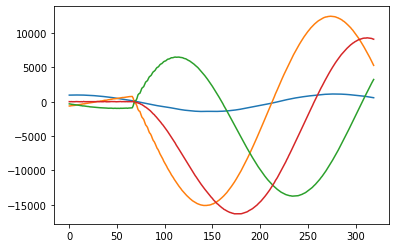

In [83]:
print(signals[0]['fault_type'])
plt.plot(signals[0]['i_cycle_1'][:320])
plt.plot(signals[0]['i_cycle_1'][320:640])
plt.plot(signals[0]['i_cycle_1'][640:960])
plt.plot(signals[0]['i_cycle_1'][960:]);

In [86]:
signals[0]['i_cycle_2'].shape

(768,)

In [90]:
576 + 192

768

BCT


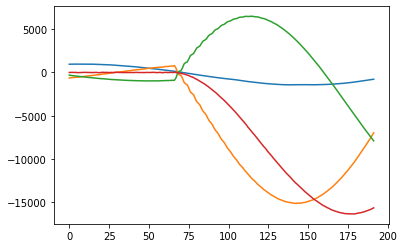

In [92]:
print(signals[0]['fault_type'])
plt.plot(signals[0]['i_cycle_2'][:192])
plt.plot(signals[0]['i_cycle_2'][192:384])
plt.plot(signals[0]['i_cycle_2'][384:576])
plt.plot(signals[0]['i_cycle_2'][576:]);